In [ ]:
# Install necessary libraries
!pip install pandas matplotlib numpy

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
from google.colab import files
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [ ]:
# Function to upload files individually
def upload_upper_leg():
    print("Please upload the upper leg data file.")
    uploaded = files.upload()
    return list(uploaded.keys())[0]

def upload_lower_leg():
    print("Please upload the lower leg data file.")
    uploaded = files.upload()
    return list(uploaded.keys())[0]

In [ ]:
# Function to load data from uploaded files
def load_data(file_name):
    # Read the uploaded CSV file
    return pd.read_csv(file_name)

In [ ]:
# Function to perform descriptive statistics
def calculate_statistics(data, label):
    print(f"\nStatistics for {label}:\n")
    stats = data.describe()
    print(stats)
    return stats

In [ ]:
# Function to plot quaternion data and save as PNG
def plot_quaternion(data, label, time_seconds):
    # Ensure time_seconds and data have the same length
    min_length = min(len(time_seconds), len(data))
    time_seconds = time_seconds[:min_length]
    data = data[:min_length]

    plt.figure(figsize=(10, 6))
    plt.plot(time_seconds, data['Quat_W'], label='Quat_W')
    plt.plot(time_seconds, data['Quat_X'], label='Quat_X')
    plt.plot(time_seconds, data['Quat_Y'], label='Quat_Y')
    plt.plot(time_seconds, data['Quat_Z'], label='Quat_Z')
    plt.title(f'{label} Quaternion Data')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Quaternion Value')
    plt.legend()
    plot_filename = f'{label.lower().replace(" ", "_")}_quaternion_plot.png'
    plt.savefig(plot_filename)  # Save the plot as PNG
    plt.show()
    return plot_filename

In [ ]:
# Function to calculate knee angle from quaternions
def calculate_knee_angle(upper_leg_data, lower_leg_data):
    # Ensure both datasets have the same length
    min_length = min(len(upper_leg_data), len(lower_leg_data))
    upper_leg_data = upper_leg_data[:min_length]
    lower_leg_data = lower_leg_data[:min_length]

    # Extract quaternion data for both legs
    upper_leg_quat = np.array([upper_leg_data['Quat_W'], upper_leg_data['Quat_X'], upper_leg_data['Quat_Y'], upper_leg_data['Quat_Z']]).T
    lower_leg_quat = np.array([lower_leg_data['Quat_W'], lower_leg_data['Quat_X'], lower_leg_data['Quat_Y'], lower_leg_data['Quat_Z']]).T

    # Calculate the relative rotation between upper and lower leg
    relative_rotation = np.sum(upper_leg_quat * lower_leg_quat, axis=1)

    # Extract the rotation angle
    angle = 2 * np.arccos(np.clip(relative_rotation, -1.0, 1.0))

    # Convert to degrees and adjust to represent anatomical knee angle
    knee_angle = 180 - (angle * 180 / np.pi)

    # Create a time array in seconds (assuming 60 Hz sampling rate)
    time_seconds = np.arange(len(knee_angle)) / 60.0

    return knee_angle, time_seconds

In [ ]:
# Function to perform quaternion statistics
def calculate_quaternion_stats(data, label):
    print(f"\nStatistics for {label} Quaternions:\n")
    stats = data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']].describe()
    print(stats)
    return stats

In [ ]:
# Function to analyse acceleration and gyroscope data
def analyse_acceleration_gyroscope(data, sensor_type):
    accel_data = data[['Acc_X', 'Acc_Y', 'Acc_Z']].dropna()
    gyro_data = data[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].dropna()

    accel_summary = accel_data.describe()
    gyro_summary = gyro_data.describe()

    return accel_summary, gyro_summary

In [ ]:
# Function to consolidate all analysis results into one CSV file
def consolidate_results_to_csv(knee_angle, upper_quaternion_stats, upper_accel_summary, upper_gyro_summary, lower_quaternion_stats, lower_accel_summary, lower_gyro_summary):
    # Prepare structured data for knee angle
    knee_angle_stats = pd.Series(knee_angle).describe().reset_index().rename(columns={'index': 'Metric', 0: 'Knee Angle'})

    # Reset index for all the statistics to align them in the CSV
    upper_quaternion_stats = upper_quaternion_stats.reset_index().rename(columns={'index': 'Metric'})
    upper_accel_summary = upper_accel_summary.reset_index().rename(columns={'index': 'Metric'})
    upper_gyro_summary = upper_gyro_summary.reset_index().rename(columns={'index': 'Metric'})
    lower_quaternion_stats = lower_quaternion_stats.reset_index().rename(columns={'index': 'Metric'})
    lower_accel_summary = lower_accel_summary.reset_index().rename(columns={'index': 'Metric'})
    lower_gyro_summary = lower_gyro_summary.reset_index().rename(columns={'index': 'Metric'})

    # Concatenate all statistics into one dataframe
    combined_stats = pd.concat([knee_angle_stats, upper_quaternion_stats, upper_accel_summary, upper_gyro_summary, lower_quaternion_stats, lower_accel_summary, lower_gyro_summary], axis=1)

    # Save the combined result to a CSV
    combined_stats_filename = 'combined_squat_analysis_results_with_quaternion.csv'
    combined_stats.to_csv(combined_stats_filename, index=False)

    return combined_stats_filename

In [ ]:
# Updated generate_graphs function to include time-series plots
def generate_graphs(upper_leg_data, lower_leg_data, knee_angle, time_seconds):
    # Plot quaternion data for upper and lower leg
    upper_leg_plot = plot_quaternion(upper_leg_data, "Upper Leg", time_seconds)
    lower_leg_plot = plot_quaternion(lower_leg_data, "Lower Leg", time_seconds)

    # Plot knee angle over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_seconds, knee_angle, label='Knee Angle')
    plt.title('Knee Angle Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Knee Angle (degrees)')
    plt.legend()
    knee_angle_plot_filename = 'knee_angle_plot.png'
    plt.savefig(knee_angle_plot_filename)
    plt.show()

    # Generate time-series plots for acceleration and gyroscope data
    plot_accel_gyro_time_series(upper_leg_data, "Upper Leg")
    plot_accel_gyro_time_series(lower_leg_data, "Lower Leg")

    # Generate box plots for acceleration and gyroscope data
    upper_leg_accel_plot, upper_leg_gyro_plot = generate_box_plots(upper_leg_data, "Upper Leg")
    lower_leg_accel_plot, lower_leg_gyro_plot = generate_box_plots(lower_leg_data, "Lower Leg")

    return upper_leg_plot, lower_leg_plot, knee_angle_plot_filename, upper_leg_accel_plot, upper_leg_gyro_plot, lower_leg_accel_plot, lower_leg_gyro_plot

In [ ]:
# Function to plot acceleration and gyroscope data over time
def plot_accel_gyro_time_series(data, label):
    time_seconds = np.arange(len(data)) / 60.0  # Assuming 60 Hz sampling rate

    # Plot acceleration over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_seconds, data['Acc_X'], label='Acc_X')
    plt.plot(time_seconds, data['Acc_Y'], label='Acc_Y')
    plt.plot(time_seconds, data['Acc_Z'], label='Acc_Z')
    plt.title(f'{label} Acceleration Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (m/s²)')
    plt.legend()
    plt.savefig(f'{label.lower().replace(" ", "_")}_acceleration_timeseries.png')
    plt.show()

    # Plot gyroscope data over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_seconds, data['Gyr_X'], label='Gyr_X')
    plt.plot(time_seconds, data['Gyr_Y'], label='Gyr_Y')
    plt.plot(time_seconds, data['Gyr_Z'], label='Gyr_Z')
    plt.title(f'{label} Gyroscope Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.legend()
    plt.savefig(f'{label.lower().replace(" ", "_")}_gyroscope_timeseries.png')
    plt.show()

In [ ]:
# Function to create box plots for acceleration and gyroscope data
def generate_box_plots(data, label):
    # Plot and save the acceleration box plot
    accel_filename = f'{label.lower().replace(" ", "_")}_acceleration_boxplot.png'
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data[['Acc_X', 'Acc_Y', 'Acc_Z']])
    plt.title(f'{label} Acceleration Data Distribution')
    plt.ylabel('Acceleration Value (m/s²)')
    plt.savefig(accel_filename)  # Save the acceleration plot
    plt.show()

    # Plot and save the gyroscope box plot
    gyro_filename = f'{label.lower().replace(" ", "_")}_gyroscope_boxplot.png'
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data[['Gyr_X', 'Gyr_Y', 'Gyr_Z']])
    plt.title(f'{label} Gyroscope Data Distribution')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.savefig(gyro_filename)  # Save the gyroscope plot
    plt.show()

    return accel_filename, gyro_filename  # Return filenames for zip

In [ ]:
def create_and_download_zip(combined_filename, upper_leg_plot, lower_leg_plot, knee_angle_plot_filename, upper_leg_accel_plot, upper_leg_gyro_plot, lower_leg_accel_plot, lower_leg_gyro_plot):
    zip_filename = 'squat_analysis_results.zip'
    with zipfile.ZipFile(zip_filename, 'w') as myzip:
        myzip.write(combined_filename)
        myzip.write(upper_leg_plot)
        myzip.write(lower_leg_plot)
        myzip.write(knee_angle_plot_filename)
        myzip.write(upper_leg_accel_plot)
        myzip.write(upper_leg_gyro_plot)
        myzip.write(lower_leg_accel_plot)
        myzip.write(lower_leg_gyro_plot)
        myzip.write('upper_leg_acceleration_timeseries.png')
        myzip.write('upper_leg_gyroscope_timeseries.png')
        myzip.write('lower_leg_acceleration_timeseries.png')
        myzip.write('lower_leg_gyroscope_timeseries.png')
    files.download(zip_filename)

Please upload the upper leg data file.


Saving upper_leg_D4CA6EF18281_20240929_225118.csv to upper_leg_D4CA6EF18281_20240929_225118 (2).csv
Please upload the lower leg data file.


Saving lower_leg_D4CA6EF183EA_20240929_225118.csv to lower_leg_D4CA6EF183EA_20240929_225118 (2).csv
Data shapes - Upper leg: (1870, 13), Lower leg: (1871, 13)
Processing 1870 frames

Statistics for Upper Leg Quaternions:

            Quat_W       Quat_X       Quat_Y       Quat_Z
count  1870.000000  1870.000000  1870.000000  1870.000000
mean      0.215318    -0.604695    -0.237119    -0.720321
std       0.023837     0.070638     0.044451     0.073260
min       0.046232    -0.738217    -0.344118    -0.844176
25%       0.200742    -0.668314    -0.273784    -0.780343
50%       0.215297    -0.598254    -0.234437    -0.735232
75%       0.230854    -0.546195    -0.202691    -0.657853
max       0.291117    -0.467377    -0.142763    -0.550889

Statistics for Lower Leg Quaternions:

            Quat_W       Quat_X       Quat_Y       Quat_Z
count  1871.000000  1871.000000  1871.000000  1871.000000
mean      0.524282    -0.094480    -0.821847    -0.179425
std       0.068129     0.026873     0.0480

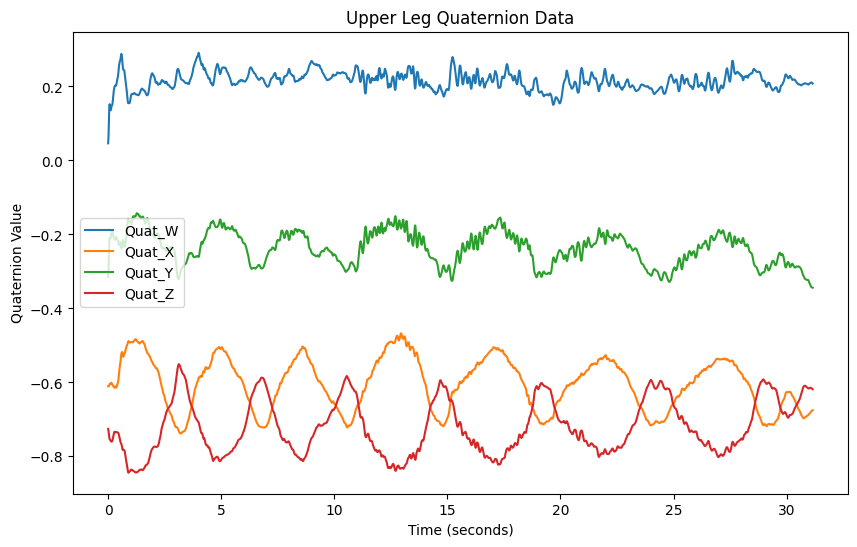

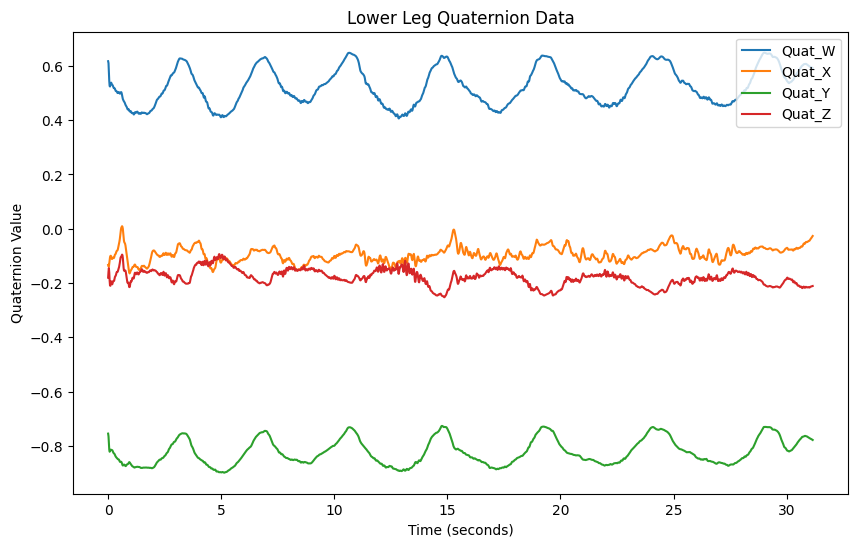

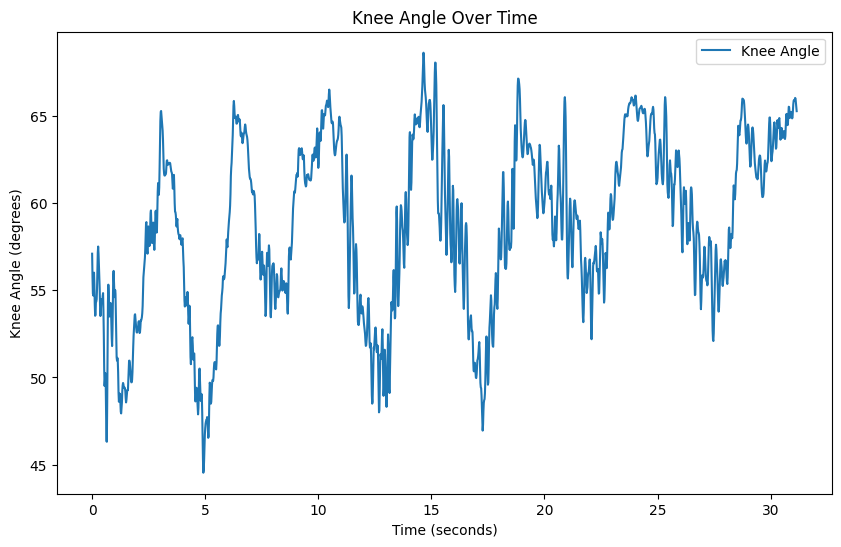

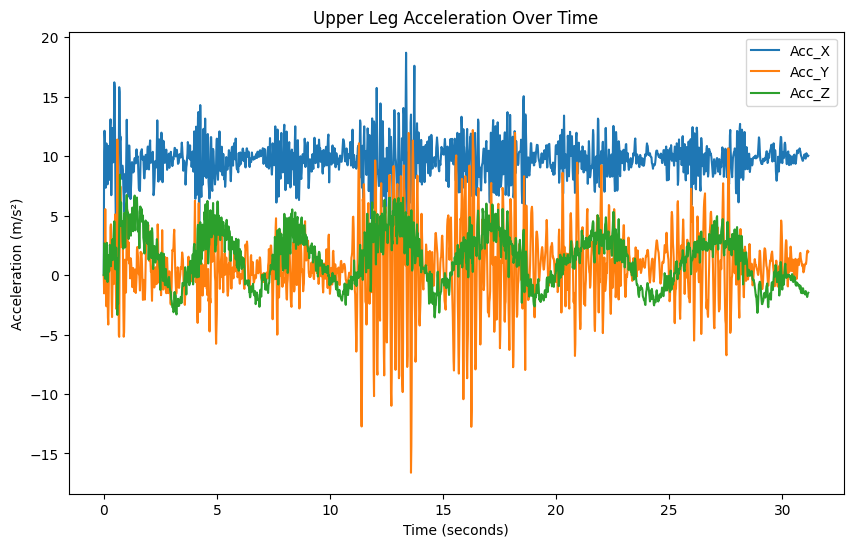

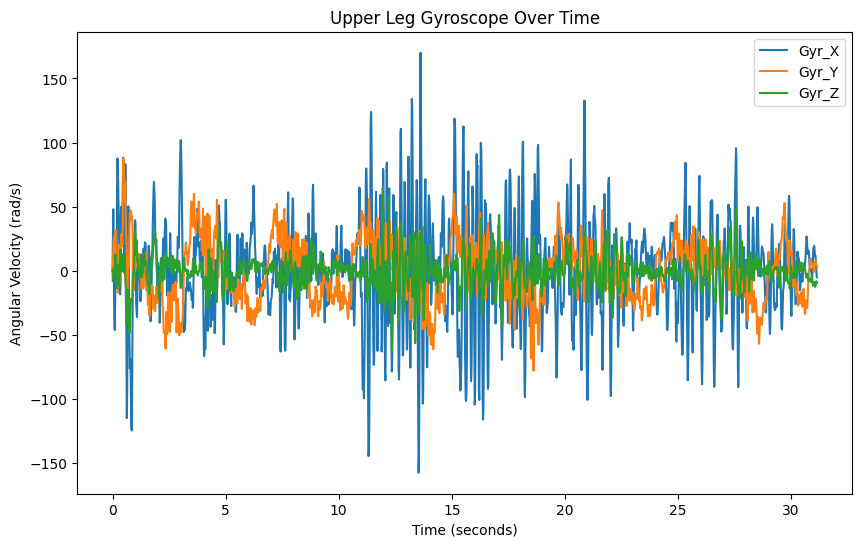

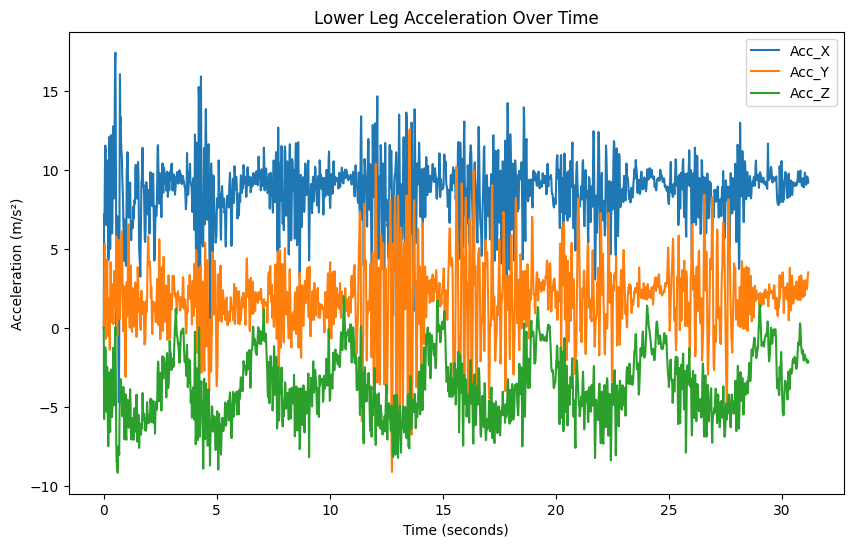

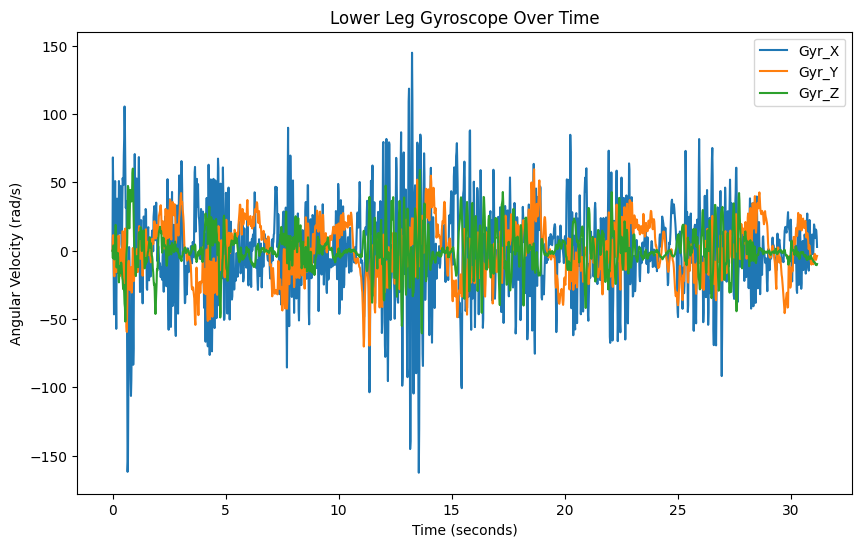

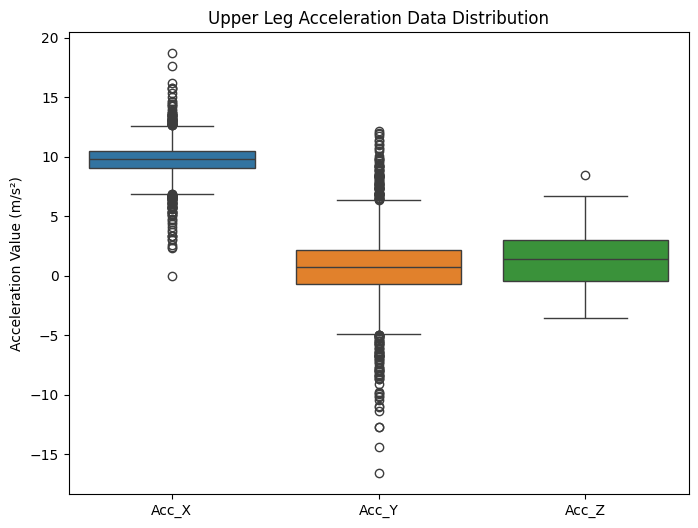

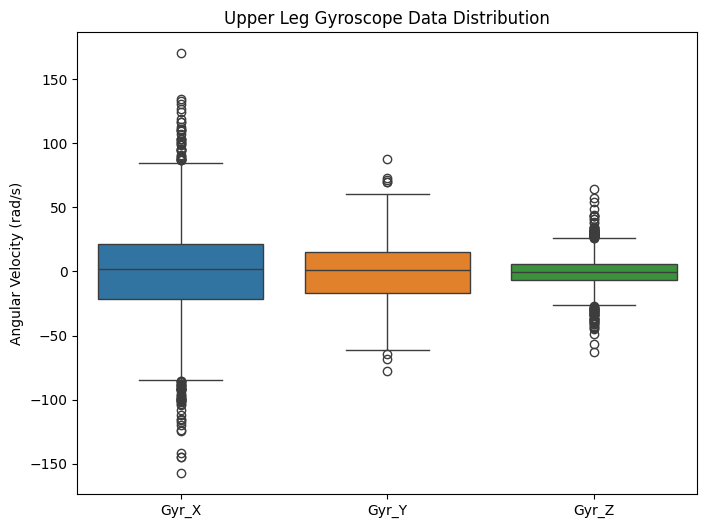

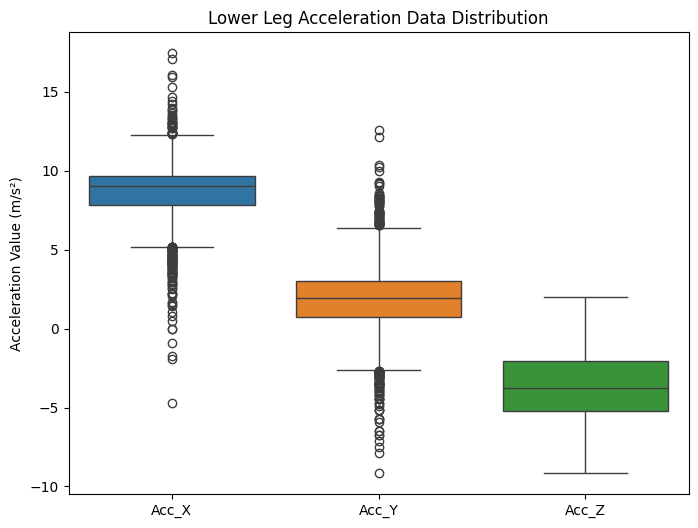

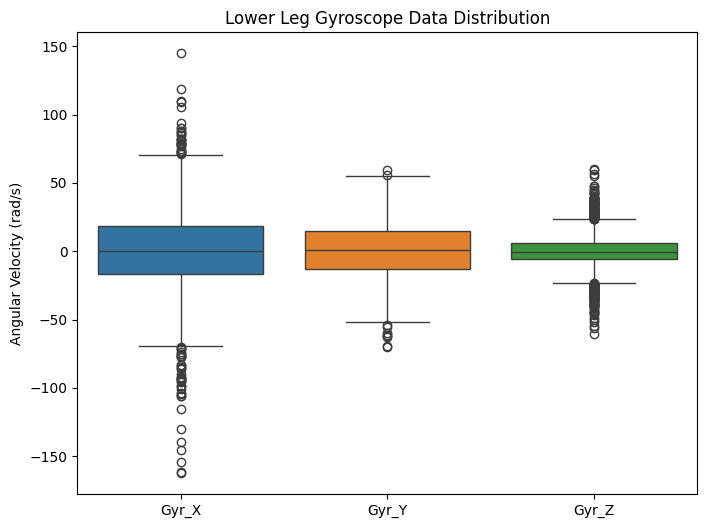

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Main analysis function to perform all analyses, generate graphs, and download results
def analyse_squat():
    # Upload upper and lower leg files
    upper_leg_file = upload_upper_leg()
    lower_leg_file = upload_lower_leg()

    # Load data
    upper_leg_data = load_data(upper_leg_file)
    lower_leg_data = load_data(lower_leg_file)

    # Perform statistics and calculate knee angle
    knee_angle, time_seconds = calculate_knee_angle(upper_leg_data, lower_leg_data)

    # Analyze quaternion statistics for upper and lower legs
    upper_quaternion_stats = calculate_quaternion_stats(upper_leg_data, "Upper Leg")
    lower_quaternion_stats = calculate_quaternion_stats(lower_leg_data, "Lower Leg")

    # Analyze acceleration and gyroscope data
    upper_accel_summary, upper_gyro_summary = analyse_acceleration_gyroscope(upper_leg_data, "Upper Leg")
    lower_accel_summary, lower_gyro_summary = analyse_acceleration_gyroscope(lower_leg_data, "Lower Leg")

    # Consolidate results into one CSV file (now including quaternion stats)
    combined_filename = consolidate_results_to_csv(knee_angle, upper_quaternion_stats, upper_accel_summary, upper_gyro_summary, lower_quaternion_stats, lower_accel_summary, lower_gyro_summary)

    # Generate the necessary graphs (including box plots and time-series plots)
    upper_leg_plot, lower_leg_plot, knee_angle_plot_filename, upper_leg_accel_plot, upper_leg_gyro_plot, lower_leg_accel_plot, lower_leg_gyro_plot = generate_graphs(upper_leg_data, lower_leg_data, knee_angle, time_seconds)

    # Create and download zip with combined results and generated graphs
    create_and_download_zip(combined_filename, upper_leg_plot, lower_leg_plot, knee_angle_plot_filename, upper_leg_accel_plot, upper_leg_gyro_plot, lower_leg_accel_plot, lower_leg_gyro_plot)

# Run the analysis
analyse_squat()